In [44]:
import os
import shutil
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import Precision, Recall

import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [45]:
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    # Restrict TensorFlow to only use the first GPU
    try:
        tf.config.set_visible_devices(gpus[0], "GPU")
        logical_gpus = tf.config.list_logical_devices("GPU")
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPU


# Data Preprocessing

In [46]:
# Image Parameters
IMG_SIZE = 224
BATCH_SIZE = 32

# Model Parameters
INPUT_SHAPE = (IMG_SIZE, IMG_SIZE, 3)
FILTER1_SIZE = 32
FILTER2_SIZE = 64
FILTER_SHAPE = (3, 3)
POOL_SHAPE = (2, 2)
FULLY_CONNECT_NUM = 128
NUM_CLASSES = 3
METRICS = ["accuracy", Precision(name="precision"), Recall(name="recall")]
LEARNING_RATE = 2e-5
# Define the number of epochs
EPOCHS = 20

In [47]:
dataset_path = "dataset/input"
output_dir = "dataset/split_dataset"
os.makedirs(output_dir, exist_ok=True)

all_images = []
all_labels = []

for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)

    if os.path.isdir(class_path):
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            all_images.append(img_path)
            all_labels.append(class_name)

df = pd.DataFrame({"image": all_images, "label": all_labels})

# Split the dataset into training (60%), validation (20%), and test sets (20%)
train_df, temp_df = train_test_split(
    df, test_size=0.4, stratify=df["label"], random_state=42
)
val_df, test_df = train_test_split(
    temp_df, test_size=0.5, stratify=temp_df["label"], random_state=42
)

test_labels = test_df["label"].values
unique_labels = set(test_labels)

print(f"Total images: {len(df)}")
print(f"Unique Labels: {unique_labels})")


print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")

Total images: 15000
Unique Labels: {'squamous_cell_carcinoma', 'adenocarcinoma', 'benign'})
Training set size: 9000
Validation set size: 3000
Test set size: 3000


In [48]:
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)

val_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col="image",
    y_col="label",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True,
)

val_generator = val_datagen.flow_from_dataframe(
    val_df,
    x_col="image",
    y_col="label",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False,
)

test_generator = val_datagen.flow_from_dataframe(
    test_df,
    x_col="image",
    y_col="label",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False,
)

Found 9000 validated image filenames belonging to 3 classes.
Found 3000 validated image filenames belonging to 3 classes.
Found 3000 validated image filenames belonging to 3 classes.


Image shape: (32, 224, 224, 3)


<Figure size 640x480 with 0 Axes>

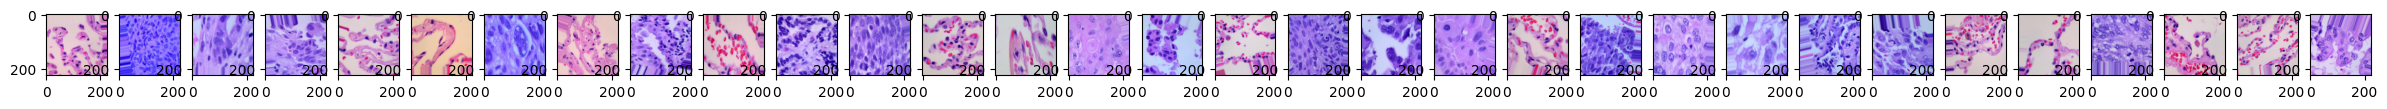

In [49]:
images, labels = train_generator[0]
print(f"Image shape: {images.shape}")

plt.figure()

# subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(1, images.shape[0], figsize=(30, 4))


for i in range(images.shape[0]):
    axarr[i].imshow(images[i])

## Initial Model

In [50]:
# Model architecture implementation
model = Sequential()
model.add(
    Conv2D(FILTER1_SIZE, FILTER_SHAPE, activation="relu", input_shape=INPUT_SHAPE)
)
model.add(MaxPooling2D(POOL_SHAPE))
model.add(Conv2D(FILTER2_SIZE, FILTER_SHAPE, activation="relu"))
model.add(MaxPooling2D(POOL_SHAPE))
model.add(Flatten())
model.add(Dense(FULLY_CONNECT_NUM, activation="relu"))
model.add(Dense(NUM_CLASSES, activation="softmax"))

model.summary()

model.compile(
    loss="categorical_crossentropy",
    optimizer=RMSprop(learning_rate=LEARNING_RATE),
    metrics=METRICS,
)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 111, 111, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 54, 54, 64)       0         
 g2D)                                                            
                                                                 
 flatten_5 (Flatten)         (None, 186624)            0         
                                                                 
 dense_13 (Dense)            (None, 128)              

In [51]:
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
)

acc = history.history["accuracy"]
loss = history.history["loss"]

Epoch 1/20
282/282 [==============================] - 75s 265ms/step - loss: 0.5662 - accuracy: 0.7139 - precision: 0.7589 - recall: 0.6444 - val_loss: 0.4599 - val_accuracy: 0.7607 - val_precision: 0.7686 - val_recall: 0.7430
Epoch 2/20
282/282 [==============================] - 73s 258ms/step - loss: 0.4325 - accuracy: 0.7980 - precision: 0.8035 - recall: 0.7879 - val_loss: 0.4475 - val_accuracy: 0.7987 - val_precision: 0.7991 - val_recall: 0.7957
Epoch 3/20
282/282 [==============================] - 72s 254ms/step - loss: 0.3969 - accuracy: 0.8202 - precision: 0.8247 - recall: 0.8151 - val_loss: 0.4137 - val_accuracy: 0.8270 - val_precision: 0.8273 - val_recall: 0.8270
Epoch 4/20
282/282 [==============================] - 73s 259ms/step - loss: 0.3684 - accuracy: 0.8306 - precision: 0.8337 - recall: 0.8280 - val_loss: 0.3625 - val_accuracy: 0.8413 - val_precision: 0.8421 - val_recall: 0.8407
Epoch 5/20
282/282 [==============================] - 76s 270ms/step - loss: 0.3529 - accura

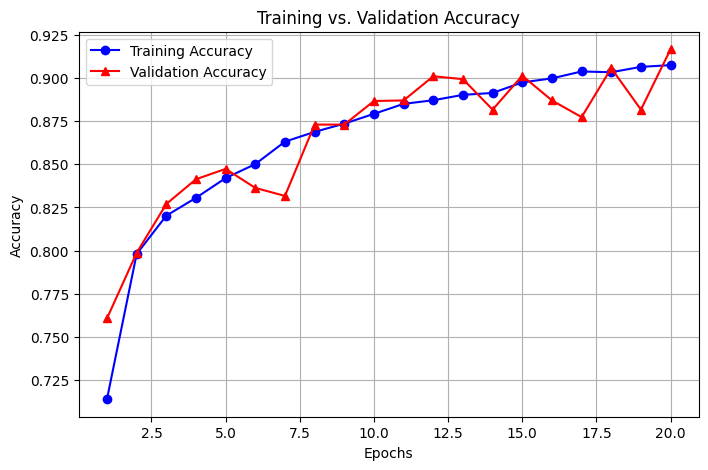

In [52]:
# Extract accuracty values
train_loss = history.history["accuracy"]
val_loss = history.history["val_accuracy"]
epochs = range(1, len(train_loss) + 1)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(
    epochs, train_loss, "bo-", label="Training Accuracy"
)  # 'bo-' = blue circles with a solid line
plt.plot(
    epochs, val_loss, "r^-", label="Validation Accuracy"
)  # 'r^-' = red triangles with a solid line
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs. Validation Accuracy")
plt.legend()
plt.grid()
plt.show()

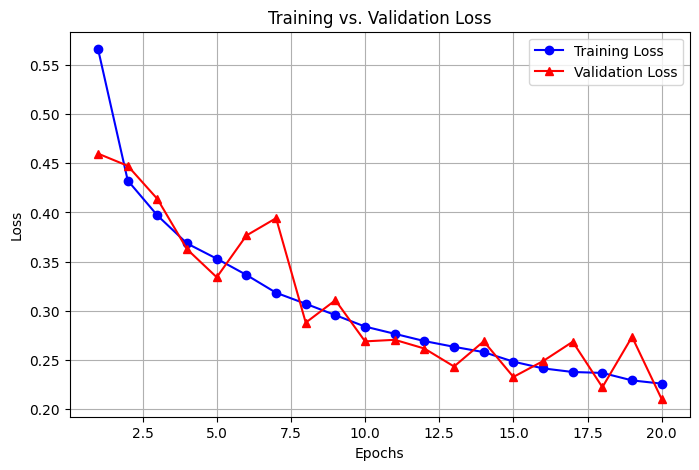

In [53]:
train_loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(train_loss) + 1)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(
    epochs, train_loss, "bo-", label="Training Loss"
)  # 'bo-' = blue circles with a solid line
plt.plot(
    epochs, val_loss, "r^-", label="Validation Loss"
)  # 'r^-' = red triangles with a solid line
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs. Validation Loss")
plt.legend()
plt.grid()
plt.show()

In [54]:
# Predictions
predictions = model.predict(test_generator)

# Model evaluation
loss, accuracy, precision, recall = model.evaluate(test_generator, steps=25)
print("\ntest acc :\n", accuracy)

25/25 [==============================] - 2s 89ms/step - loss: 0.1873 - accuracy: 0.9250 - precision: 0.9250 - recall: 0.9250

test acc :
 0.925000011920929


94/94 [==============================] - 8s 89ms/step
              precision    recall  f1-score   support

           0       0.86      0.92      0.89      1000
           1       0.99      0.96      0.97      1000
           2       0.92      0.89      0.91      1000

    accuracy                           0.92      3000
   macro avg       0.92      0.92      0.92      3000
weighted avg       0.92      0.92      0.92      3000



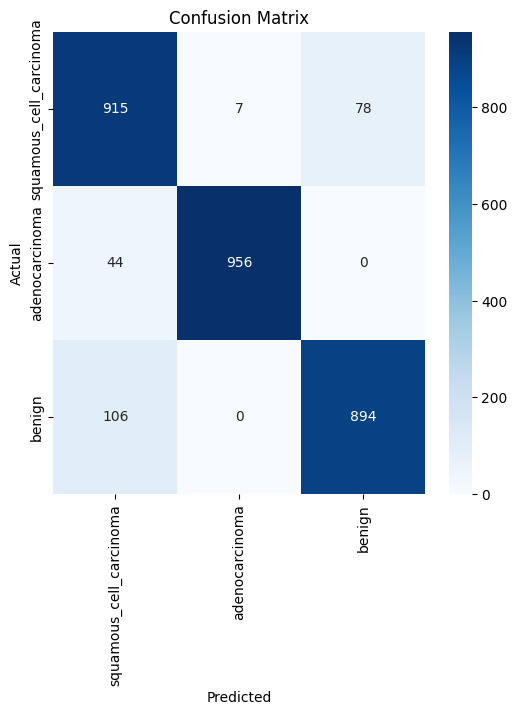

In [55]:
# Evaluate Model
y_pred = np.argmax(model.predict(test_generator), axis=1)
y_val = test_generator.classes
print(classification_report(y_val, y_pred))

#  Confusion Matrix
plt.figure(figsize=(6, 6))
sns.heatmap(
    confusion_matrix(y_val, y_pred),
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=unique_labels,
    yticklabels=unique_labels,
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

## Upgraded Model

In [62]:
# Model Parameters
INPUT_SHAPE = (IMG_SIZE, IMG_SIZE, 3)
FILTER1_SIZE = 64
FILTER2_SIZE = 32
FILTER_SHAPE = (3, 3)
POOL_SHAPE = (2, 2)
FULLY_CONNECT_NUM_1 = 256
FULLY_CONNECT_NUM_2 = 128
NUM_CLASSES = 3
METRICS = ["accuracy", Precision(name="precision"), Recall(name="recall")]
LEARNING_RATE = 1e-3
# Define the number of epochs
EPOCHS = 20

In [63]:
# Model definition
model = Sequential()

# Layer 1
model.add(
    Conv2D(FILTER1_SIZE, FILTER_SHAPE, activation="relu", input_shape=INPUT_SHAPE)
)
model.add(MaxPooling2D(pool_size=POOL_SHAPE))

# Layer 2
model.add(Conv2D(FILTER2_SIZE, FILTER_SHAPE, activation="relu"))
model.add(MaxPooling2D(pool_size=POOL_SHAPE))

# Layer 3
model.add(Conv2D(FILTER2_SIZE, FILTER_SHAPE, activation="relu"))
model.add(Dropout(0.4))

# Layer 4 - Flatten
model.add(Flatten())

# Layer 5 - Dense layers
model.add(Dense(FULLY_CONNECT_NUM_1, activation="relu"))
model.add(Dropout(0.4))
model.add(Dense(FULLY_CONNECT_NUM_2, activation="relu"))

# Output layer
model.add(Dense(NUM_CLASSES, activation="softmax"))

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss="categorical_crossentropy",
    metrics=METRICS,
)

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 222, 222, 64)      1792      
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 111, 111, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 109, 109, 32)      18464     
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 54, 54, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)          (None, 52, 52, 32)        9248      
                                                                 
 dropout_8 (Dropout)         (None, 52, 52, 32)       

In [64]:
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
)

acc = history.history["accuracy"]
loss = history.history["loss"]

Epoch 1/20
282/282 [==============================] - 71s 251ms/step - loss: 0.5207 - accuracy: 0.7491 - precision: 0.7654 - recall: 0.7230 - val_loss: 0.3519 - val_accuracy: 0.8503 - val_precision: 0.8522 - val_recall: 0.8493
Epoch 2/20
282/282 [==============================] - 70s 250ms/step - loss: 0.3528 - accuracy: 0.8566 - precision: 0.8581 - recall: 0.8537 - val_loss: 0.2806 - val_accuracy: 0.8847 - val_precision: 0.8847 - val_recall: 0.8847
Epoch 3/20
282/282 [==============================] - 76s 269ms/step - loss: 0.3287 - accuracy: 0.8681 - precision: 0.8692 - recall: 0.8664 - val_loss: 0.3073 - val_accuracy: 0.8657 - val_precision: 0.8657 - val_recall: 0.8657
Epoch 4/20
282/282 [==============================] - 76s 271ms/step - loss: 0.2838 - accuracy: 0.8848 - precision: 0.8865 - recall: 0.8837 - val_loss: 0.2474 - val_accuracy: 0.8807 - val_precision: 0.8812 - val_recall: 0.8800
Epoch 5/20
282/282 [==============================] - 73s 260ms/step - loss: 0.2592 - accura

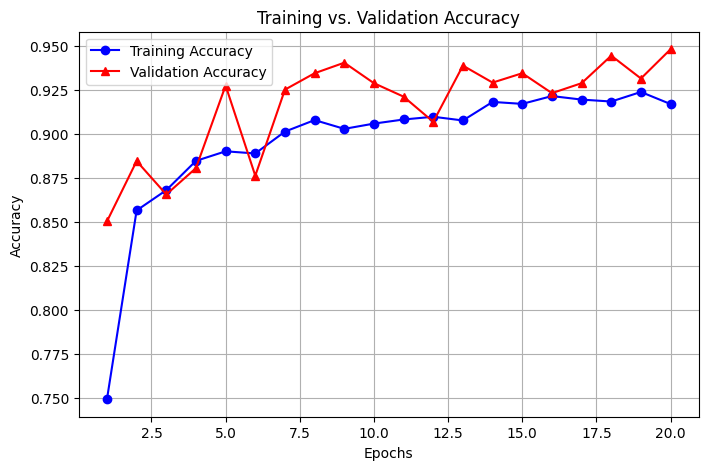

In [65]:
# Extract accuracty values
train_loss = history.history["accuracy"]
val_loss = history.history["val_accuracy"]
epochs = range(1, len(train_loss) + 1)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(
    epochs, train_loss, "bo-", label="Training Accuracy"
)  # 'bo-' = blue circles with a solid line
plt.plot(
    epochs, val_loss, "r^-", label="Validation Accuracy"
)  # 'r^-' = red triangles with a solid line
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs. Validation Accuracy")
plt.legend()
plt.grid()
plt.show()

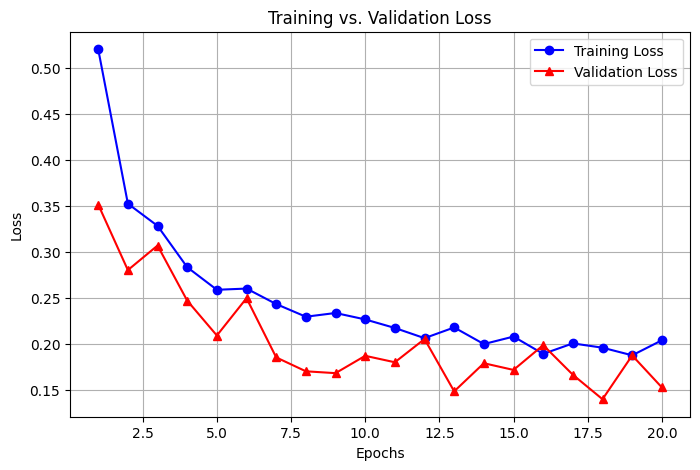

In [67]:
train_loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(train_loss) + 1)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(
    epochs, train_loss, "bo-", label="Training Loss"
)  # 'bo-' = blue circles with a solid line
plt.plot(
    epochs, val_loss, "r^-", label="Validation Loss"
)  # 'r^-' = red triangles with a solid line
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs. Validation Loss")
plt.legend()
plt.grid()
plt.show()

In [68]:
# Predictions
predictions = model.predict(test_generator)

# Model evaluation
loss, accuracy, precision, recall = model.evaluate(test_generator, steps=25)
print("\ntest acc :\n", accuracy)

25/25 [==============================] - 2s 93ms/step - loss: 0.1413 - accuracy: 0.9563 - precision: 0.9563 - recall: 0.9563

test acc :
 0.956250011920929


94/94 [==============================] - 9s 97ms/step
              precision    recall  f1-score   support

           0       0.92      0.94      0.93      1000
           1       1.00      1.00      1.00      1000
           2       0.95      0.92      0.93      1000

    accuracy                           0.95      3000
   macro avg       0.95      0.95      0.95      3000
weighted avg       0.95      0.95      0.95      3000



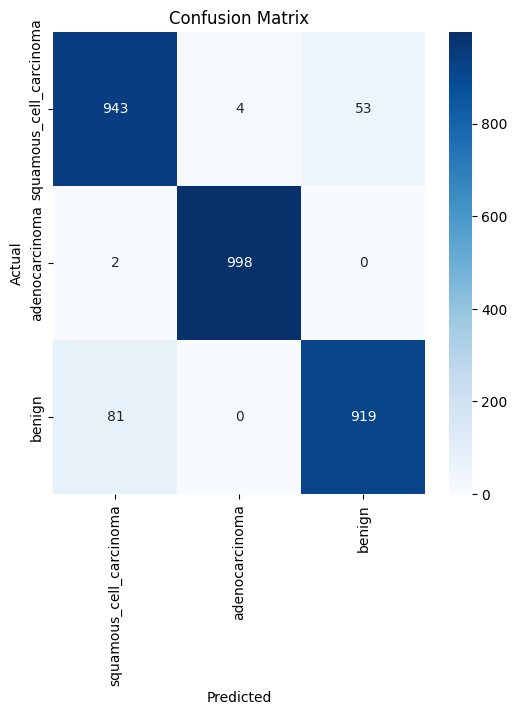

In [69]:
# Evaluate Model
y_pred = np.argmax(model.predict(test_generator), axis=1)
y_val = test_generator.classes
print(classification_report(y_val, y_pred))

#  Confusion Matrix
plt.figure(figsize=(6, 6))
sns.heatmap(
    confusion_matrix(y_val, y_pred),
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=unique_labels,
    yticklabels=unique_labels,
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()